## Topometric Registration Demo

In [69]:
import _pickle as pkl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import shapely.geometry as geo
import subprocess
import sys

In [70]:
# File paths
devens_map_file = '/home/jatavalk/code/TopometricRegistration/devensData/devens_map/devens_map_poly.pkl'
osm_nodes_file = '/home/jatavalk/code/TopometricRegistration/devensData/devens_osm/osm_nodes.txt'
osm_edges_file = '/home/jatavalk/code/TopometricRegistration/devensData/devens_osm/osm_edges.txt'
cloud_file = '/home/jatavalk/datasets/devens/scans_in_utm_annotated_small.pkl'
plot_dir = '/home/jatavalk/code/TopometricRegistration/cache/'

ceres_build_dir = '/home/jatavalk/code/TopometricRegistration/ceresCode/build/'
ceres_input_dir = '/home/jatavalk/code/TopometricRegistration/ceresCode/data/'

In [71]:
# Load in data
devens_map = pkl.load(open(devens_map_file, 'rb'), encoding = 'bytes')
osm_nodes = np.genfromtxt(osm_nodes_file, delimiter = ',')
osm_edges = np.genfromtxt(osm_edges_file, delimiter = ',', dtype = int)
cloud = pd.read_pickle(cloud_file)

### Load up a scan and perform alignment

In [72]:
scan_idx = 0

scan = cloud.iloc[scan_idx]['scan_utm']
road_mask = cloud.iloc[scan_idx]['is_road_truth']
road_mask = np.where(road_mask)
xmin = min(scan['x'])
xmax = max(scan['x'])
ymin = min(scan['y'])
ymax = max(scan['y'])
# print(cloud.iloc[0]['is_road_truth'])
# print(xmin, xmax, ymin, ymax)
# plt.plot(scan['x'], scan['y'], '.', ms=1)

# plot_coords = lambda obj: plt.plot(obj.xy[0],obj.xy[1], 'k')
# plot_coords(devens_map.exterior)
# [plot_coords(x) for x in devens_map.interiors]
# plt.plot((xmin+xmax)/2,(ymin+ymax)/2,'gx')

# Extract OSM nodes that are within the distance threshold
osm_thresh = 20.
xinds = np.where(np.logical_and(osm_nodes[:,0] > xmin, osm_nodes[:,0] < xmax))
yinds = np.where(np.logical_and(osm_nodes[:,1] > ymin, osm_nodes[:,1] < ymax))
osm_inds = np.intersect1d(xinds, yinds)

# Active set of OSM nodes
osm_nodes_active = osm_nodes[osm_inds]

# Extract LiDAR scan points that correspond to road
scan_active = scan[road_mask]
# print(scan_active, scan_active.shape)
scan_active = np.asarray([[item[0] for item in scan_active], [item[1] for item in scan_active]]).T


In [64]:
# Create input files for Ceres
ceres_input_file_osm = os.path.join(ceres_input_dir, 'osm_nodes_noisy.txt')
infile_osm = open(ceres_input_file_osm, 'w')
infile_osm.write(str(osm_nodes_active.shape[0]) + '\n')
for node in osm_nodes_active:
    infile_osm.write(str(node[0]) + ' ' + str(node[1]) + '\n')
infile_osm.close()

ceres_input_file_road = os.path.join(ceres_input_dir, 'road.txt')
infile_road = open(ceres_input_file_road, 'w')
infile_road.write(str(scan_active.shape[0]) + '\n')
for node in scan_active:
    infile_road.write(str(node[0]) + ' ' + str(node[1]) + '\n')
infile_road.close()

In [ ]:
# Run the optimizer
# ceres_command = ceres_build_dir + 'topometricRegistration'
ceres_command = '/home/jatavalk/code/TopometricRegistration/ceresCode/build/topometricRegistration'
subprocess.call(ceres_command, stdout = sys.stdout)

In [87]:
# Read in the results
ceres_output_file = os.path.join(ceres_input_dir, 'output.txt')
osm_nodes_optimized = np.copy(osm_nodes_active)
outfile = open(ceres_output_file)
lines = outfile.readlines()
# print(osm_nodes_active.shape)
i = 0
for line in lines:
    if i == 0:
        i += 1
        continue
    line = line.strip().split()
    osm_nodes_optimized[i-1,0] = line[0]
    osm_nodes_optimized[i-1,1] = line[1]
    i += 1
    
# print(osm_nodes_optimized)

(17, 2)


IndexError: index 109 is out of bounds for axis 0 with size 17

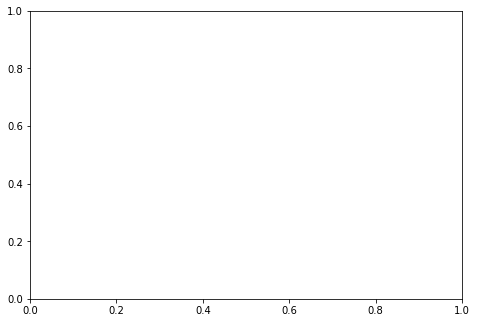

In [93]:
# Plot results

# print(osm_edges)
osm_edges_active = []
for edge in osm_edges:
    if edge[0] in osm_inds and edge[1] in osm_inds:
        osm_edges_active.append(edge)
osm_edges_active = np.asarray(osm_edges_active)
# print(osm_edges_active)

G_init = nx.Graph()
G_init.add_nodes_from(range(len(osm_nodes_active)))
G_init.add_edges_from(osm_edges_active)

nx.draw(G_init, pos = osm_nodes_active)


152
(111360,) (111360,)


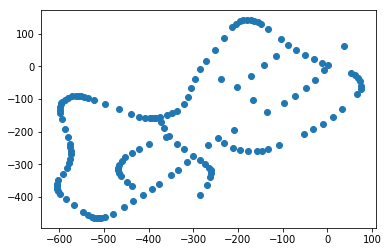

In [5]:
# Get road points
interior_pts = None
i = 0
for obj in devens_map.interiors:
	if i >= 4:
		if interior_pts is None:
			interior_pts = np.concatenate([np.expand_dims(obj.xy[0], axis=1), np.expand_dims(obj.xy[1], axis=1)], axis=1)	
		else:
			interior_pts = np.concatenate([interior_pts, np.concatenate([np.expand_dims(obj.xy[0], axis = 1), np.expand_dims(obj.xy[1], axis = 1)], \
				axis = 1)], axis = 0)
		# print(interior_pts.shape)
		# plt.plot(obj.xy[0], obj.xy[1], 'k')
	i += 1

# plt.scatter(interior_pts[:,0], interior_pts[:,1])
# plt.savefig(plot_dir + 'tmp.png')


# # Compute an approximate bounding rectangle of the road points
# x_min = np.min(interior_pts[:,0])
# x_max = np.max(interior_pts[:,0])
# y_min = np.min(interior_pts[:,1])
# y_max = np.max(interior_pts[:,1])

# # Get osm nodes (that are within a 10 meter radius of the approx bounding rectangle)
# osm_thresh = 10.

# osm_indices = []
# for i in range(osm_nodes.shape[0]):
# 	if x_min < osm_nodes[i,0] < x_max and y_min < osm_nodes[i,1] < y_max:
# 		osm_indices.append(i)

# Compute the centroid of the road points
x_cent = np.mean(interior_pts[:,0])
y_cent = np.mean(interior_pts[:,1])

# Get OSM nodes that are within a distance threshold from the centroid
osm_thresh = 10000.
osm_indices = []
for i in range(osm_nodes.shape[0]):
	if np.sqrt((osm_nodes[i,0]-x_cent)**2 + (osm_nodes[i,1]-y_cent)**2) <= osm_thresh:
		osm_indices.append(i)
print(len(osm_indices))
plt.scatter([osm_nodes[i,0] for i in osm_indices], [osm_nodes[i,1] for i in osm_indices])
plt.savefig(plot_dir + 'tmp.png')


scan = cloud.iloc[0]['scan_utm']
print(scan['x'].shape, scan['y'].shape)